# Quality on Weak Scaling Benchmark Graphs

See the Weak Scaling Runtime Notebook for the main experiment.
This notebook additionally reports the similarities to the ground truths.
This experiment also includes graphs with 1, 2, 4, 8 and 16 Million nodes which were not used in the actual weak scaling.

In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    df.to_csv("../../paper/plots/" + name + ".csv")
    if 'yerr' in kwargs:
        kwargs['yerr'].to_csv("../../paper/plots/" + name + "_std_err.csv")

In [3]:
data = {}

paths = glob.glob("../../data/results/weak_scaling/*.json") # weak scaling results
paths += glob.glob("../../data/results/weak_scaling_cmp/*.json") # comparison to ground truth
paths += glob.glob("../../data/results/weak_scaling_ground_truth//*.json") # clustering data of ground truth
paths += glob.glob("../../data/results/weak_scaling_small_quality/**/*.json", recursive=True) # data on additional small graphs

for path in paths:
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Cont.'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [5]:
comparison_data = frames['clustering'] \
    .merge(frames['clustering_comparison'], left_index=True, right_on='compare_clustering_id') \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['node_count', 'algorithm'])

## Average NMI similarities to ground truth

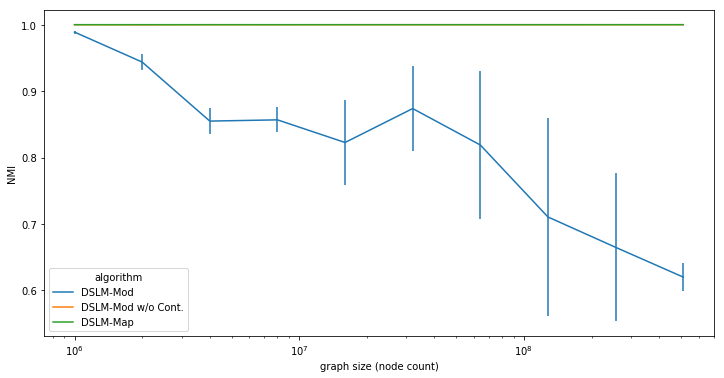

In [6]:
nmi_mean = comparison_data['NMI'].mean().to_frame().unstack() \
    ["NMI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]
    
nmi_err = comparison_data['NMI'].std().to_frame().unstack() \
    ["NMI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

plot_and_save(nmi_mean, "weak_scaling_NMI", yerr=nmi_err, ylabel="NMI", xlabel="graph size (node count)", logx=True, figsize=(12, 6))

## Average ARI similarities to ground truth

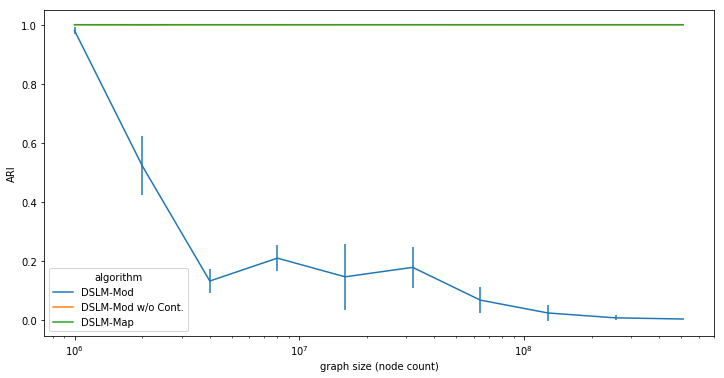

In [7]:
ari_mean = comparison_data['ARI'].mean().to_frame().unstack() \
    ["ARI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]
    
ari_err = comparison_data['ARI'].std().to_frame().unstack() \
    ["ARI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

plot_and_save(ari_mean, "weak_scaling_ARI", yerr=ari_err, ylabel="ARI", xlabel="graph size (node count)", logx=True, figsize=(12, 6))